In [49]:
import os
import sys
import glob
#import subprocess
import shutil

import numpy as np
import torch

repos_mlps_dir = os.path.dirname(os.getcwd())
sys.path.append(repos_mlps_dir)
import default_settings as default
from data.preprocess import Preprocessor
from utils import load_config, load_model, make_directory, set_seed

sys.path.append(default.repos_dir)
from vocoders import hifigan as hfg

from sak import display as dp
from vocoders import default_settings as default_vcd

In [2]:
class Inference():
    def __init__(
        self,
        preprocessor_config_path,
        checkpoint_path
        ):
        self.preprocessor_config = load_config(preprocessor_config_path)
        self.preprocessor = Preprocessor(self.preprocessor_config)
        self.model = load_model(checkpoint_path, eval=True)

    
    def load_notes(self, mid_path, txt_path):
        notes, phonemes = self.preprocessor.prepare_inference(
            mid_path, txt_path
        )
        return notes, phonemes
    
    
    def inference(self, notes, phonemes, mel_path=None):
        chunk_size = self.model.seq_len
        preds = []
        total_len = len(notes)
        notes = notes.to(device)
        phonemes = phonemes.to(device)
        remainder = total_len % chunk_size
        mel_dim = self.preprocessor_config.n_mel_channels
        
        ## inference.
        #@torch.no_grad()
        if remainder:
            pad_size = chunk_size - remainder
            padding = torch.zeros(pad_size, dtype=int).to(device)
            phonemes = torch.cat((phonemes, padding))
            notes = torch.cat((notes, padding))
            batch_phonemes = phonemes.reshape(-1, chunk_size)
            batch_notes = notes.reshape(-1, chunk_size)
            preds = self.model(batch_notes, batch_phonemes)
            preds = preds.reshape(-1, mel_dim)[:-pad_size]
        else:
            batch_phonemes = phonemes.reshape(-1, chunk_size)
            batch_notes = notes.reshape(-1, chunk_size)
            preds = self.model(batch_notes, batch_phonemes)
            mel_dim = preds.size(-1)
            preds = preds.reshape(-1, mel_dim)
        preds = preds.transpose(0, 1).unsqueeze(0)
        
        if not mel_path==None:
            np.save(mel_path, preds.detach().numpy())
        
        return preds

## Initialize.

In [3]:
## experimental settings.
device = "cpu" # 'cpu' or 'cuda'

# MLP_singer.
svs_dir  = r'/home/akikun/projects/svs'
work_dir = os.path.join(svs_dir, 'csd_hifigan_universal')

checkpoint_path = os.path.join(work_dir, 'checkpoints', 'trained', 'best.pt')
preprocessor_config_path = os.path.join(work_dir, 'configs', 'preprocess.json')

# hifi_gan.
checkpoint_hifigan_path = r'/home/akikun/common/pre_trained_vocoders/hifigan/g_02500000'

In [4]:
## svs
infer = Inference(
    preprocessor_config_path, 
    checkpoint_path
)

## hifigan.
global h
h = hfg.load_config(default_vcd.hifigan_config_path)
global device_vocode
generator, device_vocode = hfg.load_model(default_vcd.hifigan_model_path, h)

Loading '/home/akikun/common/pre_trained_vocoders/hifigan/g_02500000'
Complete.
Removing weight norm...


## Inference.

In [5]:
def svs(mid_path, txt_path, mel_path, pred_path):
    ## load notes and phonemes. 
    notes, phonemes = infer.load_notes(mid_path, txt_path)

    ## inference.
    preds = infer.inference(notes, phonemes, mel_path=mel_path)

    ## vocode.
    x = preds.cpu().detach().numpy()
    mel = torch.FloatTensor(x).to(device_vocode)
    hfg.vocode(mel, generator, h, pred_path)

In [6]:
## directories.

# data directory in where the directory 'wav', 'mid' and 'txt' are included.
data_dir = os.path.join(svs_dir, 'data')

# the directory where the predicted wav will be saved.
pred_dir = os.path.join(work_dir, 'preds')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

# the directory where the predicted mel will be saved.
mel_dir = os.path.join(work_dir, 'mel')
if not os.path.exists(mel_dir):
    os.makedirs(mel_dir)

In [13]:
## wav id to infer.
#song = 'kr001a'
wav_paths = glob.glob(os.path.join(data_dir, 'wav', '*.wav'))
song_ids  = [os.path.basename(wav_path).replace('.wav', '') for wav_path in wav_paths]

for song_id in song_ids:
    print(song_id)
    
    # input
    mid_path = os.path.join(data_dir, "mid", f"{song_id}.mid")
    txt_path = os.path.join(data_dir, "txt", f"{song_id}.txt")

    # output
    mel_path  = os.path.join(mel_dir, f"{song_id}.npy")
    pred_path = os.path.join(pred_dir, f"{song_id}.wav")

    # inference.
    svs(mid_path, txt_path, mel_path, pred_path)

kr001a
kr001b
kr002a
kr002b
kr003a
kr003b
kr004a
kr004b
kr005a
kr005b
kr006a
kr006b
kr007a
kr007b
kr008a
kr008b
kr009a
kr009b
kr010a
kr010b
kr011a
kr011b
kr012a
kr012b
kr013a
kr013b
kr014a
kr014b
kr015a
kr015b
kr016a
kr016b
kr017a
kr017b
kr018a
kr018b
kr019a
kr019b
kr020a
kr020b
kr021a
kr021b
kr022a
kr022b
kr023a
kr023b
kr024a
kr024b
kr025a
kr025b
kr026a
kr026b
kr027a
kr027b
kr028a
kr028b
kr029a
kr029b
kr030a
kr030b
kr031a
kr031b
kr032a
kr032b
kr033a
kr033b
kr034a
kr034b
kr035a
kr035b
kr036a
kr036b
kr037a
kr037b
kr038a
kr038b
kr039a
kr039b
kr040a
kr040b
kr041a
kr041b
kr042a
kr042b
kr043a
kr043b
kr044a
kr044b
kr045a
kr045b
kr046a
kr046b
kr047a
kr047b
kr048a
kr048b
kr049a
kr049b
kr050a
kr050b


## listen to the result

In [16]:
#pred0_dir = r'/home/akikun/projects/svs/csd_hifigan_universal/box/wav'
#pred0_path = os.path.join(pred0_dir, f"{song}_generated_e2e.wav")
dp.disp_wav(pred_path)
#dp.disp_wav(pred0_path)

mel = np.load(mel_path)
np.shape(mel)
# mel = mel.reshape(np.shape(mel)[1:])
# dp.disp_spectrogram(mel)

(1, 80, 12072)

In [9]:
# from sak import signal_processing as sp
# p = sp.load_wav(pred_path)
# r = sp.load_wav(raw_path)
# print(np.shape(p))
# print(np.shape(r))

## Training data for HifiGAN

In [39]:
wav_dir = os.path.join(data_dir, 'wav')
mel_dir = os.path.join(work_dir, 'mels')
voc_dir = os.path.join(work_dir, 'vocoder')

data_types = ['train', 'valid', 'test']

In [38]:
# # make train / valid / test lists.
# bin_dir = os.path.join(repos_mlps_dir, 'data', 'bin')

# for data_type in data_types:
#     pt_paths = glob.glob(os.path.join(bin_dir, data_type, '*.pt'))
#     wav_ids = [os.path.basename(pt_path).replace('.pt', '') for pt_path in pt_paths]
#     wav_ids.sort()
#     with open(os.path.join(work_dir, 'lists', data_type + '.txt'), 'w') as f:
#         f.write('\n'.join(wav_ids) + '\n')

>>> kr004a
raw: (80, 5512)
pred: (80, 5340)
>>> kr004b
raw: (80, 5512)
pred: (80, 5340)
>>> kr005a
raw: (80, 7924)
pred: (80, 7752)
>>> kr005b
raw: (80, 7924)
pred: (80, 7752)
>>> kr008a
raw: (80, 16537)
pred: (80, 16353)
>>> kr008b
raw: (80, 16537)
pred: (80, 16353)
>>> kr009a
raw: (80, 12058)
pred: (80, 11865)
>>> kr009b
raw: (80, 12058)
pred: (80, 11886)
>>> kr011b
raw: (80, 3667)
pred: (80, 3501)
>>> kr012a
raw: (80, 9772)
pred: (80, 9490)
>>> kr012b
raw: (80, 9772)
pred: (80, 9490)
>>> kr013a
raw: (80, 12698)
pred: (80, 12532)
>>> kr013b
raw: (80, 12698)
pred: (80, 12994)
>>> kr014a
raw: (80, 6408)
pred: (80, 6175)
>>> kr014b
raw: (80, 6408)
pred: (80, 6175)
>>> kr015a
raw: (80, 9302)
pred: (80, 9044)
>>> kr015b
raw: (80, 9302)
pred: (80, 9044)
>>> kr016a
raw: (80, 13906)
pred: (80, 13719)
>>> kr016b
raw: (80, 13906)
pred: (80, 13719)
>>> kr018a
raw: (80, 11684)
pred: (80, 11504)
>>> kr018b
raw: (80, 11684)
pred: (80, 11504)
>>> kr023a
raw: (80, 6323)
pred: (80, 6080)
>>> kr024a
r

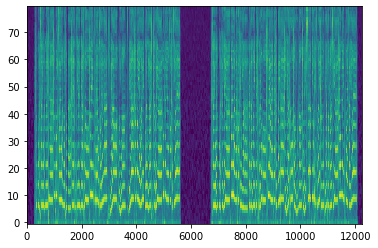

In [91]:
#for data_type in data_types:
data_type = 'train'

# load list.
with open(os.path.join(work_dir, 'lists', data_type + '.txt')) as f:
    wav_ids = f.read().strip().split('\n')

# create target directories. 
voc_wav_dir = os.path.join(voc_dir, 'wavs', data_type)
if not os.path.exists(voc_wav_dir):
    os.makedirs(voc_wav_dir)
voc_mel_dir = os.path.join(voc_dir, 'mels', data_type)
if not os.path.exists(voc_mel_dir):
    os.makedirs(voc_mel_dir)

for wav_id in wav_ids:
#for wav_id in ['kr004a']:
#wav_id = 'kr004a'
    wav_path = os.path.join(wav_dir, wav_id + '.wav')
    mel0 = hfg.extract_melspec(wav_path, h, device_vocode)
    mel0 = torch.squeeze(mel0, 0).cpu().numpy()

    mel_path = os.path.join(mel_dir, wav_id + '.npy')
    mel  = np.load(mel_path)
    _, x, y = np.shape(mel)
    mel = np.reshape(mel, (x, y))

    if np.abs(np.shape(mel0)[1] - np.shape(mel)[1]) > 24:
#            print('>>> {}'.format(wav_id))
#dp.disp_wav(wav_path)
#dp.disp_wav(os.path.join(work_dir, 'preds', wav_id + '.wav'))
#%matplotlib inline

#             shutil.copy(wav_path, os.path.join(voc_wav_dir, wav_id + '.wav'))
#             shutil.copy(mel_path, os.path.join(voc_mel_dir, wav_id + '.npy'))
#         else:
        print('>>> {}'.format(wav_id))
        dp.disp_spectrogram(mel, png_file=os.path.join(work_dir, 'fig', wav_id + '_pred.png'))
        dp.disp_spectrogram(mel0, png_file=os.path.join(work_dir, 'fig', wav_id + '_raw.png'))
        print('raw: {}'.format(np.shape(mel0)))
        print('pred: {}'.format(np.shape(mel)))

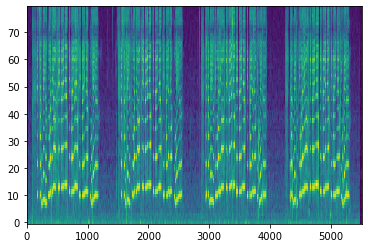

In [87]:
dp.disp_spectrogram(mel0, png_file=os.path.join(work_dir, 'fig', wav_id + '_raw.png'))

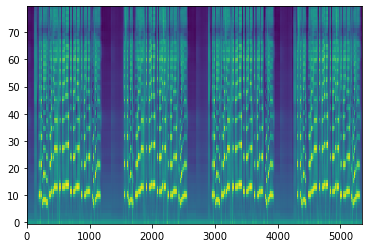

In [88]:
dp.disp_spectrogram(mel, png_file=os.path.join(work_dir, 'fig', wav_id + '_pred.png'))

In [77]:
1000/22050 * 256

11.609977324263038

In [45]:
wav_path = os.path.join(data_dir, 'wav', 'kr001a.wav')
mel = hfg.extract_melspec(wav_path, h, device_vocode)
print(np.shape(mel))
# x = mel.cpu().detach().numpy()
# mel_ = torch.FloatTensor(x).to(device_vocode)
mel_ = torch.squeeze(mel, 0)
print(np.shape(mel_))

torch.Size([1, 80, 4770])
torch.Size([80, 4770])
